## Stroke Classification

As one of the most common recurring medical conditions, stroke is a severe cause of death across the world. The most important factor in this matter is having the ability to detect early signs of the condition and take careful preventative measures. In this project, we will explore this topic in detail by building various **supervised learning models** as *classification* for how likely it is for an individual to suffer a stroke based on health, demographic and other factors. The goal of the report is to uncover observations on how likely stroke cases can be classified correctly using supervised learning. 

GitHub Repository: https://github.com/YLFengCU/DTSA-5509

### Data Source

Soriano, F. (2021, January). Stroke Prediction Dataset. Retrieved from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data. 

The source of the dataset of the project can be found above from Kaggle. In the initial stage, we will be looking to obtain a high-level overview of the dataset and perform some data cleaning to prepare the data for modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# import data
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.info()
print(f'Number of observations: {data.shape[0]}, number of features: {data.shape[1]}') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
Number of observations: 5110, number of features: 12


### Data Cleaning

From an initial view of the data, my first idea is to cleanup any NaN values residing in the BMI column for two reasons. The first is that it may be a strong predictor and second is to prevent errors from surfacing when training the model. For this context, it will suffice to impute the blanks with the mean BMI value, but to ensure this is a valid approach the distribution of BMI values will be plotted before and after inserting new values. In addition, IDs do not serve any analytical purpose as there is no mapping to other datasets and no duplicate entries so the column should be safe to remove.

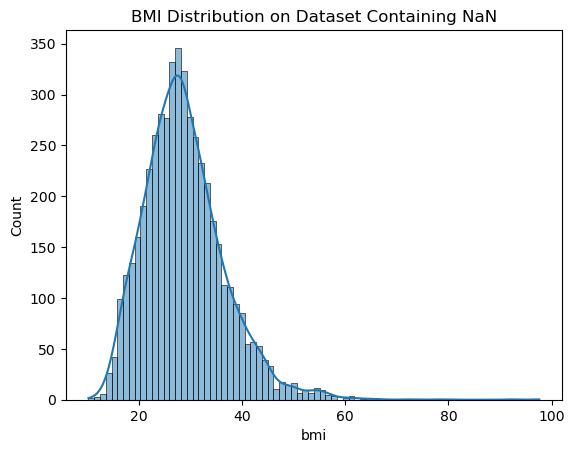

Imputed mean value: 28.893236911794666


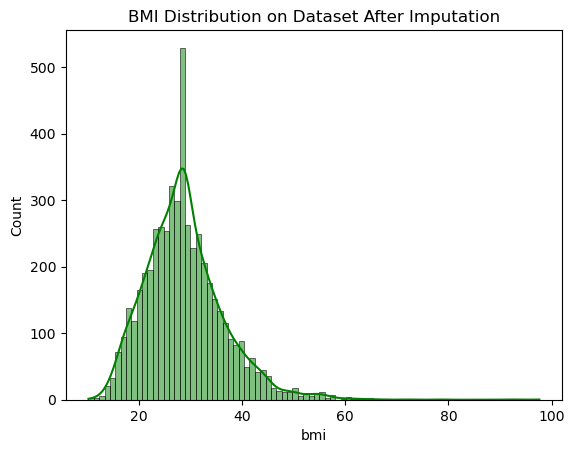

In [4]:
# plot BMI distribution on raw data
sns.histplot(data['bmi'], kde=True)
plt.title('BMI Distribution on Dataset Containing NaN')
plt.show()

# remove ID col
clean_data = data.drop('id', axis=1)
# handle NULL bmi values and impute with means
mean_bmi = data['bmi'].mean()
clean_data['bmi'] = data['bmi'].fillna(mean_bmi)
print(f'Imputed mean value: {mean_bmi}')

# plot BMI distribution post cleaning
sns.histplot(clean_data['bmi'], kde=True, color='green')
plt.title('BMI Distribution on Dataset After Imputation')
plt.show()

Visualizing the distributions of BMI values before and after imputing NaN values with the mean, the y-axis scale shifts to accomodate for the spike in mean bmi values around 29. However, the key is that the overall distribution shape is intact, since only the center of the distribution is being padded. If there were potential shifts in the distribution, we would be at risk of introducing bias but since there are no deviations, this would suggest imputing NULL values with the mean BMI was a reasonable choice. 

The final consideration in the data cleaning process is the presence of categorical variables. I considered transforming some/all of these columns into numerical values as an early patch for typing errors with decision tree models later. Ultimately, the fact that most of the categorical values had no logical ordinal encodings and it seemed best not to impose assumptions on the data as numerical values would hold less meaning than its current strings. Instead, this will be something done in the model section when it is required. However, since the **ever_married** column consists of only yes/no values, that can be converted into a binary 0 or 1.

In [5]:
# map married col to binary 0 or 1 values
clean_data['ever_married'] = clean_data['ever_married'].map({'No': 0, 'Yes': 1})
clean_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1


### Exploratory Data Analysis

Now that the data has been cleaned up, I will perform EDA on the data and take a look at the relationships that may exist between features. First, let's take a look at an initial pairplot visualization.

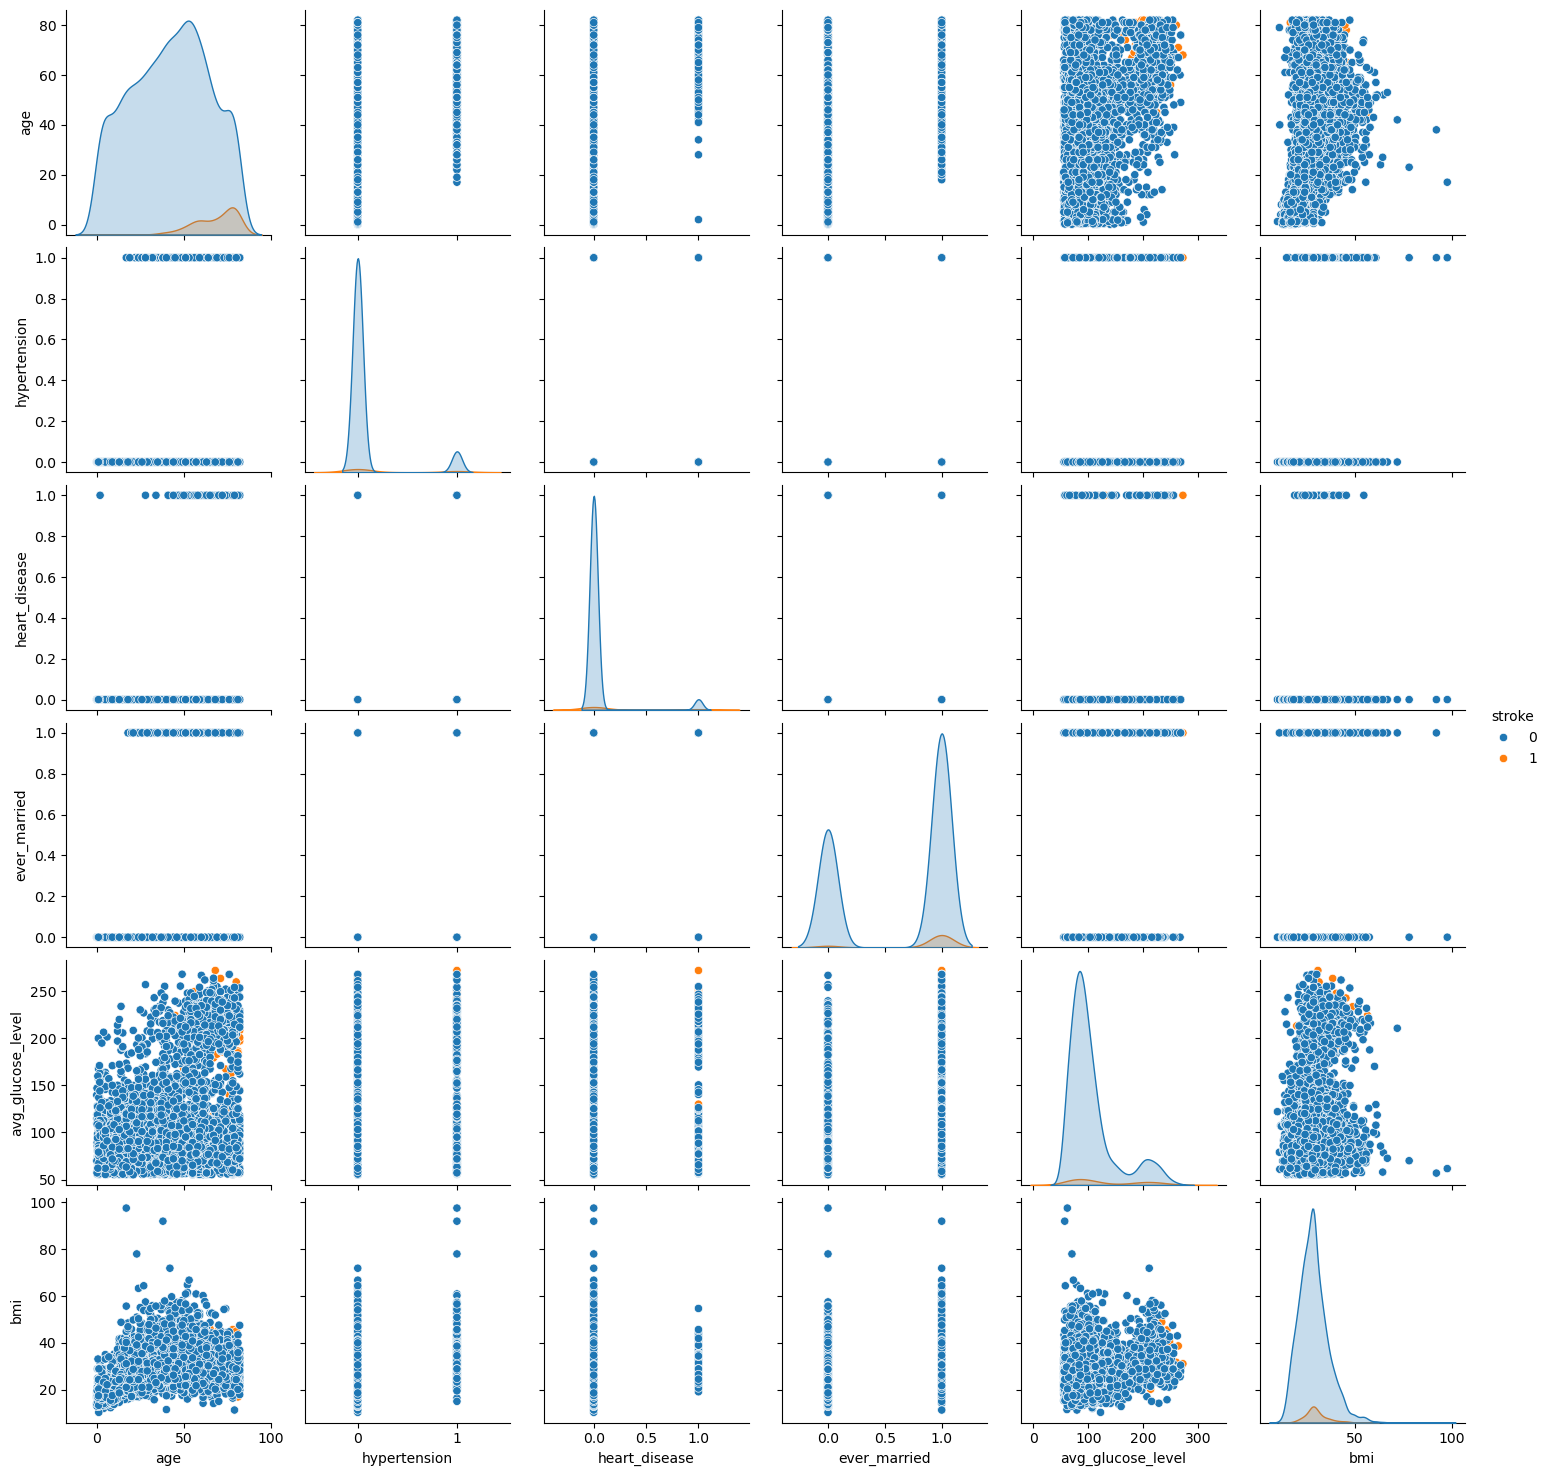

In [6]:
sns.pairplot(clean_data, hue='stroke', diag_kind='kde')
plt.show()

Immediately through the eye-test, there is an important potential issue to be identified: there seems to be a major class distribution imbalance between the stroke observations. That is, there appears to be an overwhelming number of non-stroke observations in each relationship plot (blue points). Let's analyze this further by plotting the distribution between these classes:

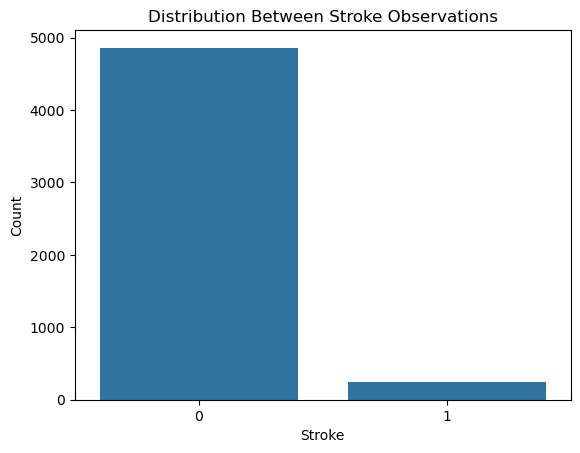

Number of stroke cases: 249, number of non-stroke cases: 4861


In [7]:
# plot distribution between stroke observations
stroke_vals = clean_data['stroke'].value_counts()
sns.barplot(x=stroke_vals.index, y=stroke_vals)
plt.title('Distribution Between Stroke Observations')
plt.ylabel('Count')
plt.xlabel('Stroke')
plt.show()
print(f'Number of stroke cases: {stroke_vals[1]}, number of non-stroke cases: {stroke_vals[0]}')

There is indeed quite a sizable class imbalance in the dataset. It would be difficult to overcome this challenge for supervised learning especially, as performance metrics including accuracy and recall scores will suffer heavily. Intuitively, having a small subset of stroke cases would mean a poor train-test split could lead to the supervised model having a small number of positive stroke cases to learn from. 

One solution here would be to apply weights or consider oversampling and undersampling between the two subsets. Looking at external resources online, it looks like the most widely used solution is resampling. A great writeup can be found from this source: https://semaphoreci.com/blog/imbalanced-data-machine-learning-python. 

The gist of it comes down to this: we can oversample from the minority class that classifies as stroke (adding more samples) or undersample from the majority class that classifies as non-stroke (removing samples). In this case, let's attempt to implement this adjustment by applying oversampling to positive stroke observations.

(9722, 11)


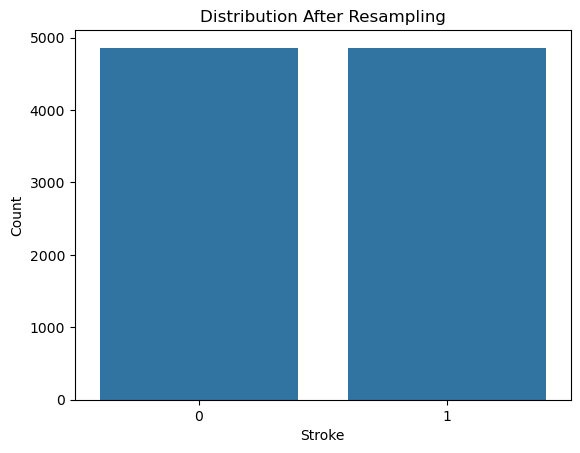

In [8]:
# apply oversampling 
X = clean_data.drop(columns='stroke')
# y need to contain imbalanced col
y = clean_data['stroke']

# random over sampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
resampled_X, resampled_y = ros.fit_resample(X, y)

# reconstruct data with resamples
resampled_data = pd.DataFrame(resampled_X, columns=resampled_X.columns)
resampled_data['stroke'] = resampled_y
print(resampled_data.shape)

# plot new distribution across stroke
new_stroke_vals = resampled_y.value_counts()
sns.barplot(x=new_stroke_vals.index, y=new_stroke_vals)
plt.title('Distribution After Resampling')
plt.ylabel('Count')
plt.xlabel('Stroke')
plt.show()

Now we have successfully balanced the classes in the dataset and resolved the issue. It is time to move on to creating and training supervised models. Since resampling is a major part of the project, it would make sense to run models on both the resampled data as well as the data without resampling to compare performance.

In [9]:
# corr matrix does not make sense with the abundance of categorical variables
# sns.heatmap(resampled_data.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

### Build and Train Supervised Models

The non-parametric supervised models I selected will include decision trees and K-nearest neighbors. Let's get started with a decision tree classifier first.

In [10]:
# convert strings to numerical encodings (using labelencoder) for decision tree classifier calculations
cols = ['gender', 'work_type', 'Residence_type', 'smoking_status']
label_encoder = LabelEncoder()
# encode each col's values
for col in cols:
    resampled_X[col] = label_encoder.fit_transform(resampled_X[col])

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.2, random_state=42)

In [11]:
# build and train a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# make preds using model
preds = dt_model.predict(X_test)
print(preds, preds.shape)

[0 1 0 ... 1 0 1] (1945,)


Now that a decision tree classifier model has been trained, let's analyze the results using a few of the key metrics learned from lecture. Then, we will train a decision tree model on the original dataset without resampling for comparison.

Decision Tree Classifier Accuracy: 0.9820051413881749
Decision Tree Classifier Recall Score: 1.0


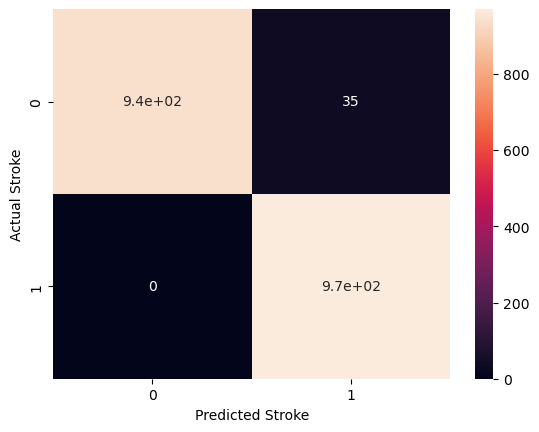

In [12]:
# evaluate model 
dt_accuracy = accuracy_score(y_test, preds)
dt_recall_score = recall_score(y_test, preds)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy}')
print(f'Decision Tree Classifier Recall Score: {dt_recall_score}')

# show confusion matrix
dt_conf_mat = confusion_matrix(y_test, preds)
sns.heatmap(dt_conf_mat, annot=True)
plt.xlabel('Predicted Stroke')
plt.ylabel('Actual Stroke')
plt.show()

In [13]:
# for comparison, run model on original (not resampled) dataset
cols = ['gender', 'work_type', 'Residence_type', 'smoking_status']
label_encoder = LabelEncoder()
# encode orig col's values
for col in cols:
    X[col] = label_encoder.fit_transform(X[col])

# split data into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

dt_og_model = DecisionTreeClassifier(random_state=42)
dt_og_model.fit(X_train1, y_train1)

# make preds using model
preds = dt_og_model.predict(X_test1)

# evaluate model 
dt_og_accuracy = accuracy_score(y_test1, preds)
dt_og_recall_score = recall_score(y_test1, preds)
print(f'Decision Tree Classifier Accuracy (Without Resampling): {dt_og_accuracy}')
print(f'Decision Tree Classifier Recall Score (Without Resampling): {dt_og_recall_score}')

Decision Tree Classifier Accuracy (Without Resampling): 0.9119373776908023
Decision Tree Classifier Recall Score (Without Resampling): 0.16129032258064516


From what we can see, there is a tremendous difference when the resampling technique was applied to the dataset. This is evident in the difference in recall score, a perfect score was achieved in the model's ability to classify all positive samples while the original data yielded a very poor recall. Intuitively, this makes sense as it is harder for the model to classify positive stroke cases when there is a class imbalance present and there are less true positive cases to train from. In terms of the overall accuracy, training a decision tree model with the resampled dataset performs extremely well.

Now, let's try to perform some hyperparameter tuning to see how the decision tree classifier's performance changes. The main properties that will be adjusted here will be: max tree depth in combination with different criterion (defaults to Gini) to measure a split.

Best parameters found from grid search params tuning: {'criterion': 'entropy', 'max_depth': 30} with accuracy: 0.9750534390266079


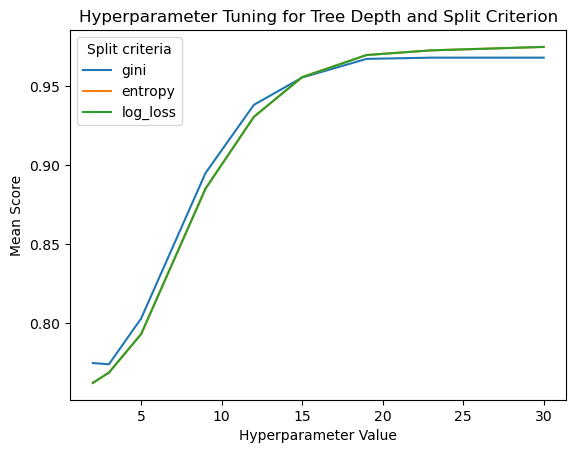

In [14]:
# define hyperparams to tune
params = {
    'max_depth': [2, 3, 5, 9, 12, 15, 19, 23, 30],
    'criterion': ['gini', 'entropy', 'log_loss']
}

dt_base = DecisionTreeClassifier(random_state=42)
# use grid search CV for tuning
grid_search = GridSearchCV(estimator=dt_base, param_grid=params, cv=5)
grid_search.fit(X_train, y_train)
print(f'Best parameters found from grid search params tuning: {grid_search.best_params_} with accuracy: {grid_search.best_score_}')

sns.lineplot(data=grid_search.cv_results_, x='param_max_depth', y='mean_test_score', hue='param_criterion')
plt.title('Hyperparameter Tuning for Tree Depth and Split Criterion')
plt.xlabel('Hyperparameter Value')
plt.ylabel('Mean Score')
plt.legend(title='Split criteria')
plt.show()

Looking at the performance of different hyperparameters, we notice that the performance improves steadily but eventually levels off as the maximum depth is increased. In other words, the takeaways are that deeply nested trees (allowed to grow flexibly) are better predictors and capture the intricacies of the dataset, at the cost of complexity and risk of overfitting. It is clear that the efficiency of a tree model will not benefit from having a more complex tree structure than the above values, as accuracy has already stagnated and the cost tradeoff is poor. 

More interestingly, we can see that using the entropy (or log-loss) split criteria overtakes the gini criteria at a certain threshold even though they both compute a similar idea with information gain and impurity. There is not a meaningful performance gap by any means, so utilizing entropy as the split criteria may be suboptimal depending on efficiency. By their respective derived formulas, objectively the entropy function is computationally more expensive with the extra log function, and the performance vs time complexity trade-off analysis for much larger datasets is one that would likely favor gini as the default criteria function. 

Now, another non-parametric supervised model that is often compared against decision trees is the KNN learner. For classification, KNN takes majority vote for its K-nearest observations and requires no training step unlike decision trees. Let's quickly make this comparison before drawing some conclusions.

KNN Classifier Accuracy: 0.9362795477903392
KNN Classifier Recall Score: 1.0


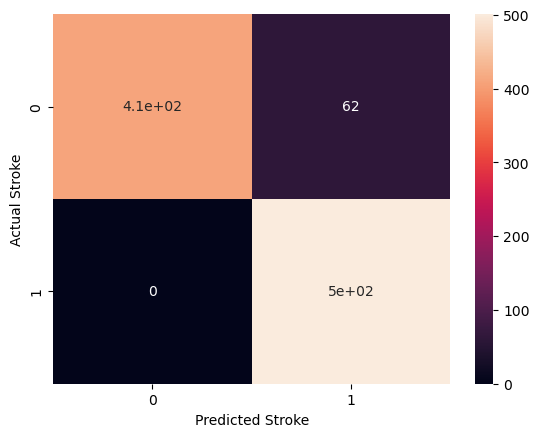

In [19]:
# split data into training and test sets
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(resampled_X, resampled_y, test_size=0.1, random_state=42)

# build KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(knn_X_train, knn_y_train)

# obtain set of preds
knn_preds = knn.predict(knn_X_test)

# evaluate model 
knn_accuracy = accuracy_score(knn_y_test, knn_preds)
knn_recall_score = recall_score(knn_y_test, knn_preds)
print(f'KNN Classifier Accuracy: {knn_accuracy}')
print(f'KNN Classifier Recall Score: {knn_recall_score}')

# show confusion matrix
knn_conf_mat = confusion_matrix(knn_y_test, knn_preds)
sns.heatmap(knn_conf_mat, annot=True)
plt.xlabel('Predicted Stroke')
plt.ylabel('Actual Stroke')
plt.show()

In [20]:
# split data into training and test sets
knn_X_train1, knn_X_test1, knn_y_train1, knn_y_test1 = train_test_split(X, y, test_size=0.1, random_state=42)

# as with decision trees, also build model based on non-resampled data
knn_og = KNeighborsClassifier(n_neighbors=5)
knn_og.fit(knn_X_train1, knn_y_train1)

# obtain set of preds
knn_preds = knn_og.predict(knn_X_test1)

# evaluate model 
knn_og_accuracy = accuracy_score(knn_y_test1, knn_preds)
knn_og_recall_score = recall_score(knn_y_test1, knn_preds)
print(f'KNN Classifier Accuracy (Without Resampling): {knn_og_accuracy}')
print(f'KNN Classifier Recall Score (Without Resampling): {knn_og_recall_score}')

KNN Classifier Accuracy (Without Resampling): 0.9412915851272016
KNN Classifier Recall Score (Without Resampling): 0.0


The KNN model for classification clearly performs worse than the decision tree in terms of prediction accuracy. Interestingly, all of its misclassifications are false positives in which an incorrect identification of a stroke case was made. What is more shocking, is the fact that without resampling the dataset, KNN has a 0 recall, indicating that it fails to predict any of the stroke cases. If this is indeed the case, the model may as well be useless (without resampling) for the context of the project. To dive into this issue, we will look at the KNN confusion matrix results for the non-resampled data.

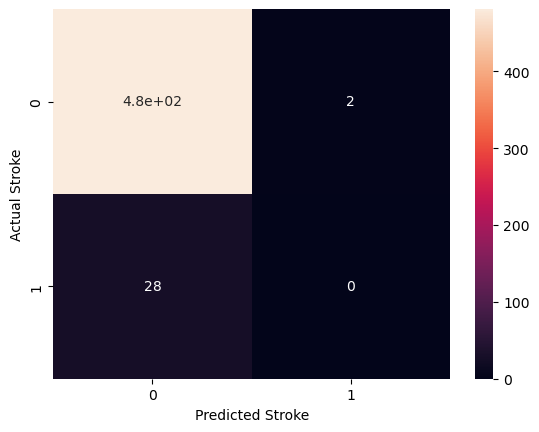

In [17]:
knn_conf_mat1 = confusion_matrix(knn_y_test1, knn_preds)
sns.heatmap(knn_conf_mat1, annot=True)
plt.xlabel('Predicted Stroke')
plt.ylabel('Actual Stroke')
plt.show()

As we can see, if we performed KNN classification on the uncleaned dataset, a total of 2 positive stroke case predictions were made (all incorrect). This highlights the limitations of the KNN model as it struggles heavily when dealing with the problem of imbalanced classes, more so than the decision tree model. Without applying the resampling technique, there would be no meaningful predictions for analysis. 

The final thing we will do is to search for an optimal K value on the KNN model utilizing the resampled dataset.

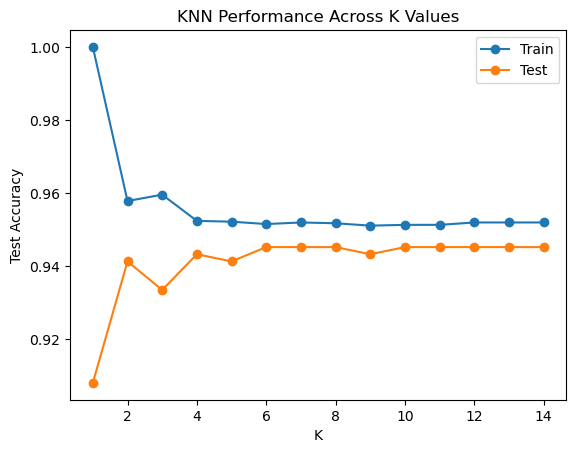

In [21]:
# search for optimal K param
knn_train_accs = []
knn_test_accs = []
ks = range(1, 15)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_X_train1, knn_y_train1)
    
    # compute both train and test preds
    train_preds = knn.predict(knn_X_train1)
    train_acc = accuracy_score(knn_y_train1, train_preds)
    knn_train_accs.append(train_acc)
    
    test_preds = knn.predict(knn_X_test1)
    test_acc = accuracy_score(knn_y_test1, test_preds)
    knn_test_accs.append(test_acc)

# print(knn_test_accs)
# plot performance across K vals
plt.plot(ks, knn_train_accs, label='Train', marker='o')
plt.plot(ks, knn_test_accs, label='Test', marker='o')
plt.title('KNN Performance Across K Values')
plt.xlabel('K')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

A K value in the range of [6-8] nearest neighbors yields a good performing test accuracy that steadily levels off afterward and there is no value in increasing complexity of the model. We have to be mindful here without further analysis though, as using a very low K value with high performance such as k = 2 may not generalize well across different datasets by only considering the two nearest data points. Overall, KNN was a model that is highly impacted by the flaws of the dataset, which will transition us to the conclusion of the report to discuss some key takeaways.

### Conclusion

After working with the stroke dataset from Kaggle performing data cleaning, EDA and supervised modelling and analysis, there were a number of key takeaways found that I will now summarize. Our two non-parametric supervised learning models of decision trees and KNN classifiers performed well on a resampled dataset, specifically managing to predict every single true positive stroke case. That brings us to our next key takeaway, which is that the process of transforming the dataset as part of the EDA process was one the most important task of the project. Without oversampling the positive stroke cases, both models would not be at all useful for analyical purposes for the project's goals. 

On that note, the issue of class (label) imbalancing also presented the major challenge faced. As seen from running separate models on the unadjusted dataset versus the resampled dataset that featured a balanced distribution of stroke and non-stroke cases, we get vastly different interpretations of the model where one produced good performance results while the other was not a viable prediction tool at all. This challenge was significant for both models but the KNN model in particular, which was unable to correctly identify any of the true positive stroke data points.

While the rebalancing of classes was a fine solution for the scope of this project, potential next steps would be to perform extensive resampling experiments to find the optimal balancing split of classes as opposed to simply oversampling to get a 50-50 split for both classes in this project. There is far from a guarantee that the current approach will not backfire to the point where we are introducing bias, since the original split of stroke cases was so insignificant that (over) oversampling may also harm the model training. Furthermore, implementing increased supervised learning such as ensembling techniques, SVM or logistic regression would all be interesting model choices for additional analysis.

Thank you for taking the time to read the findings of this stroke classification project.